# **Predictive Modeling for Football Match Outcomes**

## **Objective**
Build machine learning models to predict football match outcomes based on network metrics using advanced validation techniques.

## **Key Improvements**
1. **Hold-out Test Set**: 15% of matches isolated before any model training
2. **GroupKFold Cross-Validation**: Prevents data leakage between match records
3. **Nested Cross-Validation**: Unbiased hyperparameter tuning
4. **Learning Curves**: Analyze model learning behavior and detect overfitting
5. **Comprehensive Evaluation**: Final performance on untouched hold-out set

## **Methodology**
Uses team network metric differences as features to predict which team wins, with rigorous validation to ensure reliable performance estimates.

## **1. Environment Setup**

In [1]:
from pathlib import Path
from typing import List, Tuple, Dict, Any

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, GroupKFold, GridSearchCV, 
    learning_curve, cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, confusion_matrix, accuracy_score, 
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not installed. Proceeding without XGBoost.")

import shap

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **2. Data Loading and Initial Preparation**

In [2]:
# Configure paths
DATA_PATH = Path("../data")
PROCESSED_DATA_PATH = DATA_PATH / "processed"
NETWORKS_PATH = PROCESSED_DATA_PATH / "on_ball_networks.parquet"

# Load network data
if not NETWORKS_PATH.exists():
    raise FileNotFoundError(f"Network data not found: {NETWORKS_PATH}")

print("Loading network data...")
networks_df = pd.read_parquet(NETWORKS_PATH)
print(f"✓ Loaded {len(networks_df)} network records")
print(f"✓ Unique matches: {networks_df['match_id'].nunique()}")
print(f"✓ Columns: {len(networks_df.columns)}")

Loading network data...
✓ Loaded 4050 network records
✓ Unique matches: 2025
✓ Columns: 37


In [3]:
def prepare_modeling_data(networks_df: pd.DataFrame) -> pd.DataFrame:
    """Prepare data for modeling by removing non-feature columns."""
    
    # Columns to remove (keep only numerical features and required identifiers)
    columns_to_remove = [
        'team', 'team_id', 'time_interval',
        'home_or_away', 'home_abbrev_name', 'away_abbrev_name',
        'score_interval_momentum', 'score_final', 'goal_in_match'
    ]
    
    # Remove only existing columns
    existing_columns_to_remove = [
        col for col in columns_to_remove 
        if col in networks_df.columns
    ]
    
    modeling_df = networks_df.drop(columns=existing_columns_to_remove)
    
    # Verify required columns exist
    required_columns = ['match_id', 'final_result']
    missing_columns = [col for col in required_columns if col not in modeling_df.columns]
    
    if missing_columns:
        raise ValueError(f"Required columns missing: {missing_columns}")
    
    print(f"✓ Prepared modeling data with {len(modeling_df.columns)} columns")
    print(f"✓ Features removed: {len(existing_columns_to_remove)}")
    
    return modeling_df


# Prepare data for modeling
modeling_data = prepare_modeling_data(networks_df)

✓ Prepared modeling data with 30 columns
✓ Features removed: 7


In [4]:
# Data exploration
print("\n=== DATA EXPLORATION ===")
print(f"Final shape: {modeling_data.shape}")
print(f"Available columns: {list(modeling_data.columns)}")


=== DATA EXPLORATION ===
Final shape: (4050, 30)
Available columns: ['match_id', 'final_result', 'edge_count', 'network_density', 'avg_in_degree', 'std_in_degree', 'avg_out_degree', 'std_out_degree', 'avg_betweenness', 'std_betweenness', 'max_betweenness', 'avg_pagerank', 'std_pagerank', 'avg_eigenvector', 'std_eigenvector', 'avg_clustering', 'std_clustering', 'transitivity', 'triangle_count', 'reciprocity', 'assortativity', 'modularity', 'num_cycles', 'spectral_radius', 'fiedler_value', 'edge_weight_entropy', 'avg_katz', 'std_katz', 'avg_harmonic_closeness', 'std_harmonic_closeness']


## **3. Team Comparison Dataset Creation**

In [5]:
def create_team_comparisons(modeling_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create pairwise team comparisons for each match.
    
    For each match, creates two comparison records:
    1. Winner - Loser (target = 1)
    2. Loser - Winner (target = 0)
    """
    print("Creating team comparison dataset...")
    
    comparisons = []
    processed_matches = 0
    skipped_matches = 0
    
    # Process each match
    for match_id, match_data in modeling_df.groupby('match_id'):
        teams = match_data.copy()
        
        # Ensure exactly 2 teams per match
        if len(teams) != 2:
            skipped_matches += 1
            continue
        
        # Sort by final_result (winner first)
        teams = teams.sort_values('final_result', ascending=False).reset_index(drop=True)
        
        winning_team = teams.iloc[0]  # final_result = 1
        losing_team = teams.iloc[1]   # final_result = 0
        
        # Verify win/loss pattern
        if winning_team['final_result'] != 1 or losing_team['final_result'] != 0:
            skipped_matches += 1
            continue
        
        # Get feature columns (exclude identifiers)
        feature_columns = [
            col for col in teams.columns 
            if col not in ['match_id', 'final_result'] 
            and teams[col].dtype in ['int64', 'float64']
        ]
        
        # Create comparison 1: Winner - Loser (target = 1)
        feature_diff_win = winning_team[feature_columns] - losing_team[feature_columns]
        comparison_win = feature_diff_win.to_dict()
        comparison_win.update({
            'match_id': match_id,
            'target': 1,
            'team_1_result': winning_team['final_result'],
            'team_2_result': losing_team['final_result']
        })
        comparisons.append(comparison_win)
        
        # Create comparison 2: Loser - Winner (target = 0)
        feature_diff_loss = losing_team[feature_columns] - winning_team[feature_columns]
        comparison_loss = feature_diff_loss.to_dict()
        comparison_loss.update({
            'match_id': match_id,
            'target': 0,
            'team_1_result': losing_team['final_result'],
            'team_2_result': winning_team['final_result']
        })
        comparisons.append(comparison_loss)
        
        processed_matches += 1
    
    comparisons_df = pd.DataFrame(comparisons)
    
    print(f"✓ Processed {processed_matches} matches")
    print(f"✓ Skipped {skipped_matches} invalid matches")
    print(f"✓ Created {len(comparisons_df)} comparison records")
    
    return comparisons_df


# Create comparison dataset
comparisons_df = create_team_comparisons(modeling_data)

# Analyze comparison dataset
print("\n=== COMPARISON DATASET ANALYSIS ===")
print(f"Shape: {comparisons_df.shape}")
print(f"Target distribution:")
print(comparisons_df['target'].value_counts())

Creating team comparison dataset...
✓ Processed 2025 matches
✓ Skipped 0 invalid matches
✓ Created 4050 comparison records

=== COMPARISON DATASET ANALYSIS ===
Shape: (4050, 32)
Target distribution:
target
1    2025
0    2025
Name: count, dtype: int64


## **4. Hold-out Test Set Separation**

In [6]:
# Get unique match IDs
unique_matches = comparisons_df['match_id'].unique()
print(f"Total unique matches: {len(unique_matches)}")

# Split matches into train and hold-out test (15% for test)
train_matches, test_matches = train_test_split(
    unique_matches, 
    test_size=0.15, 
    random_state=RANDOM_STATE
)

print(f"\nMatch split:")
print(f"  Train matches: {len(train_matches)} ({len(train_matches)/len(unique_matches)*100:.1f}%)")
print(f"  Test matches: {len(test_matches)} ({len(test_matches)/len(unique_matches)*100:.1f}%)")

# Create train and test dataframes based on match_id
df_train = comparisons_df[comparisons_df['match_id'].isin(train_matches)].copy()
df_test = comparisons_df[comparisons_df['match_id'].isin(test_matches)].copy()

print(f"\nDataset sizes:")
print(f"  Train set: {len(df_train)} records")
print(f"  Test set: {len(df_test)} records")

# Verify no overlap
overlap_matches = set(df_train['match_id'].unique()) & set(df_test['match_id'].unique())
assert len(overlap_matches) == 0, "Found overlapping matches between train and test!"
print(f"\n✓ Verified: No overlapping matches between train and test sets")

Total unique matches: 2025

Match split:
  Train matches: 1721 (85.0%)
  Test matches: 304 (15.0%)

Dataset sizes:
  Train set: 3442 records
  Test set: 608 records

✓ Verified: No overlapping matches between train and test sets


## **5. Feature Preparation**

In [7]:
# Prepare features and target
feature_columns = [
    col for col in df_train.columns 
    if col not in ['match_id', 'target', 'team_1_result', 'team_2_result']
]

# Training data
X_train = df_train[feature_columns]
y_train = df_train['target']
groups_train = df_train['match_id']

# Test data (hold-out)
X_test = df_test[feature_columns]
y_test = df_test['target']

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nFeature columns ({len(feature_columns)}): {feature_columns[:5]}...")

Training set: (3442, 28)
Test set: (608, 28)

Feature columns (28): ['edge_count', 'network_density', 'avg_in_degree', 'std_in_degree', 'avg_out_degree']...


## **6. Evaluation Metrics**

In [8]:
def calculate_gmean(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate G-Mean (Geometric Mean of Sensitivity and Specificity).
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate sensitivity (TPR) and specificity (TNR)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        # G-Mean is the geometric mean of sensitivity and specificity
        gmean = np.sqrt(sensitivity * specificity)
        return gmean
    else:
        return 0.0


# Create sklearn scorer
gmean_scorer = make_scorer(calculate_gmean)

print("✓ Evaluation metrics configured")
print("  - G-Mean: Geometric mean of sensitivity and specificity")
print("  - Accuracy: Overall classification accuracy")

✓ Evaluation metrics configured
  - G-Mean: Geometric mean of sensitivity and specificity
  - Accuracy: Overall classification accuracy


## **7. Model Configuration with Hyperparameter Grids**

In [9]:
from typing import Any, Dict, List, Tuple
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

def configure_models_and_params() -> Dict[str, Tuple[Any, Dict[str, List[Any]]]]:
    """
    Configure models and their hyperparameter grids for nested CV.

    Returns:
        Dictionary with model names as keys and (model, param_grid) tuples as values.
    """
    models_and_params = {
        'Logistic Regression': (
            LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
            {
                'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                'classifier__penalty': ['l1', 'l2'],
                'classifier__solver': ['liblinear']
            }
        ),
        'Random Forest': (
            RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
            {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__max_depth': [5, 10, 15, None],
                'classifier__min_samples_split': [2, 5, 10],
                'classifier__min_samples_leaf': [1, 2, 4]
            }
        ),
        'SVM (RBF)': (
            SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE),
            {
                'classifier__C': [0.1, 1, 10, 100],
                'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
            }
        )
    }

    # Add XGBoost if available
    if XGBOOST_AVAILABLE:
        models_and_params['XGBoost'] = (
            XGBClassifier(
                use_label_encoder=False,
                eval_metric='logloss',
                random_state=RANDOM_STATE,
                verbosity=0,
                tree_method='hist',            
                predictor='cpu_predictor'      
            ),
            {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__max_depth': [3, 5, 7],
                'classifier__learning_rate': [0.01, 0.1, 0.3],
                'classifier__subsample': [0.7, 0.8, 1.0]
            }
        )

    return models_and_params

# Configure models
models_and_params = configure_models_and_params()
print(f"✓ Configured {len(models_and_params)} models with hyperparameter grids:")
for model_name in models_and_params:
    print(f"  - {model_name}")

✓ Configured 4 models with hyperparameter grids:
  - Logistic Regression
  - Random Forest
  - SVM (RBF)
  - XGBoost


## **8. Nested Cross-Validation with GroupKFold**

In [10]:
def perform_nested_cv(name: str, model: Any, param_grid: Dict[str, List[Any]], 
                     X: pd.DataFrame, y: pd.Series, groups: pd.Series,
                     n_outer_folds: int = 5, n_inner_folds: int = 3) -> Dict[str, Any]:
    """
    Perform nested cross-validation with GroupKFold to prevent data leakage.
    
    - Outer loop: Estimates generalization performance
    - Inner loop: Selects best hyperparameters
    """
    print(f"\n{'='*60}")
    print(f"Evaluating {name} with Nested CV...")
    print(f"Outer folds: {n_outer_folds}, Inner folds: {n_inner_folds}")
    
    # Create pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Outer CV for performance estimation
    outer_cv = GroupKFold(n_splits=n_outer_folds)
    
    # Results storage
    outer_scores_gmean = []
    outer_scores_accuracy = []
    best_params_list = []
    
    fold_num = 0
    for train_idx, test_idx in outer_cv.split(X, y, groups):
        fold_num += 1
        print(f"\nOuter Fold {fold_num}/{n_outer_folds}...")
        
        # Split data for this outer fold
        X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
        y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
        groups_train_outer = groups.iloc[train_idx]
        
        # Inner CV for hyperparameter tuning
        inner_cv = GroupKFold(n_splits=n_inner_folds)
        
        # Grid search with inner CV
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=inner_cv,
            scoring=gmean_scorer,
            n_jobs=-1,
            verbose=0
        )
        
        # Fit grid search (finds best params on inner CV)
        grid_search.fit(X_train_outer, y_train_outer, groups=groups_train_outer)
        
        # Store best parameters
        best_params_list.append(grid_search.best_params_)
        
        # Evaluate on outer test fold with best model
        y_pred = grid_search.predict(X_test_outer)
        
        gmean_score = calculate_gmean(y_test_outer, y_pred)
        accuracy_score_value = accuracy_score(y_test_outer, y_pred)
        
        outer_scores_gmean.append(gmean_score)
        outer_scores_accuracy.append(accuracy_score_value)
        
        print(f"  G-Mean: {gmean_score:.4f}, Accuracy: {accuracy_score_value:.4f}")
        print(f"  Best params: {grid_search.best_params_}")
    
    # Calculate summary statistics
    results = {
        'model_name': name,
        'mean_gmean': np.mean(outer_scores_gmean),
        'std_gmean': np.std(outer_scores_gmean),
        'mean_accuracy': np.mean(outer_scores_accuracy),
        'std_accuracy': np.std(outer_scores_accuracy),
        'gmean_scores': outer_scores_gmean,
        'accuracy_scores': outer_scores_accuracy,
        'best_params_per_fold': best_params_list
    }
    
    print(f"\n{name} Nested CV Results:")
    print(f"  Mean G-Mean: {results['mean_gmean']:.4f} (±{results['std_gmean']:.4f})")
    print(f"  Mean Accuracy: {results['mean_accuracy']:.4f} (±{results['std_accuracy']:.4f})")
    
    return results

In [11]:
# Perform nested CV for all models
print("\n=== NESTED CROSS-VALIDATION ===")
print(f"Using GroupKFold to prevent data leakage between match records")

nested_cv_results = {}

for model_name, (model, param_grid) in models_and_params.items():
    try:
        results = perform_nested_cv(
            name=model_name,
            model=model,
            param_grid=param_grid,
            X=X_train,
            y=y_train,
            groups=groups_train,
            n_outer_folds=5,
            n_inner_folds=3
        )
        nested_cv_results[model_name] = results
    except Exception as e:
        print(f"\nError evaluating {model_name}: {str(e)}")
        continue

print(f"\n✓ Nested CV completed for {len(nested_cv_results)} models")


=== NESTED CROSS-VALIDATION ===
Using GroupKFold to prevent data leakage between match records

Evaluating Logistic Regression with Nested CV...
Outer folds: 5, Inner folds: 3

Outer Fold 1/5...
  G-Mean: 0.7942, Accuracy: 0.7942
  Best params: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Outer Fold 2/5...
  G-Mean: 0.7645, Accuracy: 0.7645
  Best params: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Outer Fold 3/5...
  G-Mean: 0.7616, Accuracy: 0.7616
  Best params: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Outer Fold 4/5...
  G-Mean: 0.7703, Accuracy: 0.7703
  Best params: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Outer Fold 5/5...
  G-Mean: 0.7820, Accuracy: 0.7820
  Best params: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Logistic Regression Nested CV Results:
  Mean G-Me

## **9. Results Comparison**

In [12]:
def display_nested_cv_results(results: Dict[str, Dict[str, Any]]) -> pd.DataFrame:
    """
    Display formatted results table comparing all models from nested CV.
    """
    if not results:
        print("No results to display.")
        return None
    
    # Create results dataframe
    results_data = []
    for model_name, metrics in results.items():
        results_data.append({
            'Model': model_name,
            'Mean G-Mean': metrics['mean_gmean'],
            'Std G-Mean': metrics['std_gmean'],
            'Mean Accuracy': metrics['mean_accuracy'],
            'Std Accuracy': metrics['std_accuracy']
        })
    
    results_df = pd.DataFrame(results_data)
    results_df = results_df.sort_values('Mean G-Mean', ascending=False)
    
    print("\n" + "="*80)
    print("NESTED CROSS-VALIDATION RESULTS - TRAINING SET")
    print("="*80)
    print(results_df.to_string(index=False, float_format='%.4f'))
    
    # Best model
    best_model_name = results_df.iloc[0]['Model']
    print(f"\nBest Model (by G-Mean): {best_model_name}")
    
    return results_df


# Display results
results_df = display_nested_cv_results(nested_cv_results)


NESTED CROSS-VALIDATION RESULTS - TRAINING SET
              Model  Mean G-Mean  Std G-Mean  Mean Accuracy  Std Accuracy
          SVM (RBF)       0.7844      0.0114         0.7844        0.0114
Logistic Regression       0.7745      0.0121         0.7745        0.0121
            XGBoost       0.7655      0.0121         0.7655        0.0121
      Random Forest       0.7556      0.0059         0.7557        0.0059

Best Model (by G-Mean): SVM (RBF)


## **10. Learning Curves Analysis**

In [13]:
def plot_learning_curves(model_name: str, model: Any, param_grid: Dict[str, List[Any]],
                        X: pd.DataFrame, y: pd.Series, groups: pd.Series) -> None:
    """
    Plot learning curves to analyze model behavior and detect overfitting.
    """
    print(f"\nGenerating learning curves for {model_name}...")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    cv = GroupKFold(n_splits=3)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring=gmean_scorer,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X, y, groups=groups)
    best_model = grid_search.best_estimator_
    
    train_sizes = np.linspace(0.1, 1.0, 10)
    cv_lc = GroupKFold(n_splits=5)
    
    train_sizes_abs, train_scores, val_scores = learning_curve(
        best_model, X, y,
        groups=groups,
        cv=cv_lc,
        train_sizes=train_sizes,
        scoring=gmean_scorer,
        n_jobs=-1,
        verbose=0
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))

    plt.plot(train_sizes_abs, train_mean, 'o-', color='#06478f', label='Training Score', 
             linewidth=2, markersize=6, markeredgecolor='black', markeredgewidth=0.8)
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='#06478f')
    
    plt.plot(train_sizes_abs, val_mean, 'o-', color='#b01f16', label='Validation Score', 
             linewidth=2, markersize=6, markeredgecolor='black', markeredgewidth=0.8)
    plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='#b01f16')
    
    ax = plt.gca()
    
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['bottom'].set_linewidth(1.0)

    plt.xlabel('Training Set Size', fontweight='bold')
    plt.ylabel('G-Mean Score', fontweight='bold')
    plt.title(f'Learning Curves - {model_name}', fontweight='bold', fontsize=14)

    legend = plt.legend(loc='lower right')
    for text in legend.get_texts():
        text.set_fontweight('bold')
    legend.get_frame().set_edgecolor('black')

    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

    final_gap = train_mean[-1] - val_mean[-1]
    print(f"\nAnalysis for {model_name}:")
    print(f"  Final training score: {train_mean[-1]:.4f}")
    print(f"  Final validation score: {val_mean[-1]:.4f}")
    print(f"  Gap (potential overfitting): {final_gap:.4f}")
    
    if final_gap > 0.1:
        print("  ⚠️  High gap suggests overfitting")
    elif final_gap > 0.05:
        print("  ⚡ Moderate gap, some overfitting")
    else:
        print("  ✓ Low gap, good generalization")


=== LEARNING CURVES ANALYSIS ===
Analyzing learning behavior and overfitting for top models...

Generating learning curves for SVM (RBF)...


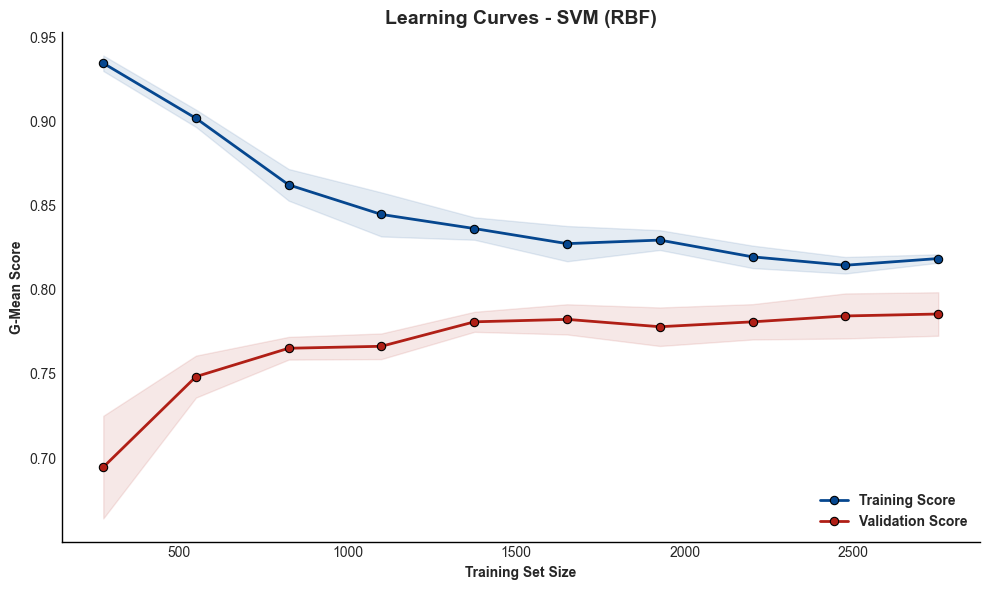


Analysis for SVM (RBF):
  Final training score: 0.8185
  Final validation score: 0.7856
  Gap (potential overfitting): 0.0330
  ✓ Low gap, good generalization

Generating learning curves for Logistic Regression...


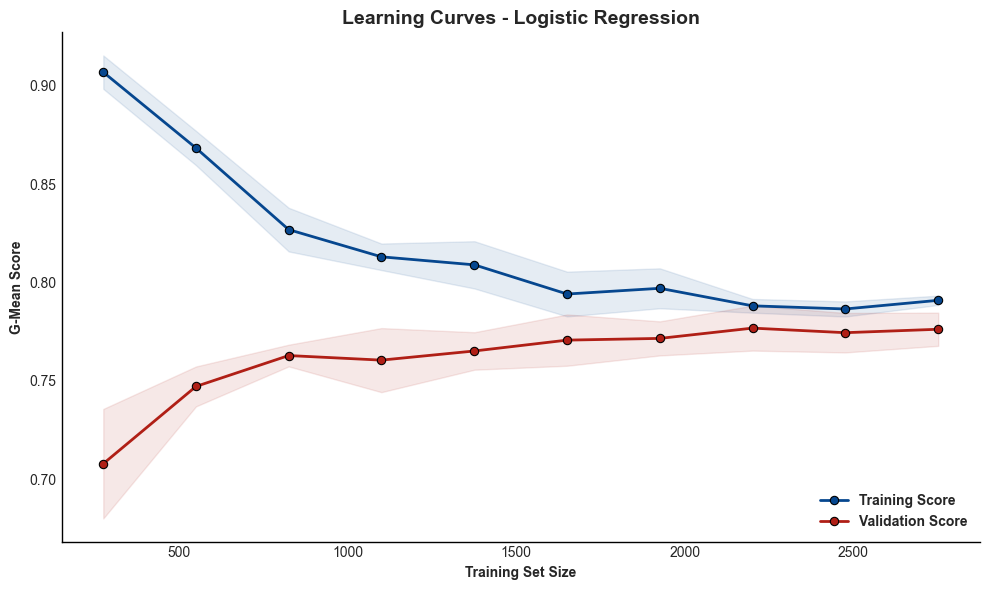


Analysis for Logistic Regression:
  Final training score: 0.7910
  Final validation score: 0.7763
  Gap (potential overfitting): 0.0147
  ✓ Low gap, good generalization


In [14]:
# Generate learning curves for top 2 models
if results_df is not None and len(results_df) >= 2:
    top_models = results_df.head(2)['Model'].values
    
    print("\n=== LEARNING CURVES ANALYSIS ===")
    print("Analyzing learning behavior and overfitting for top models...")
    
    for model_name in top_models:
        if model_name in models_and_params:
            model, param_grid = models_and_params[model_name]
            plot_learning_curves(
                model_name=model_name,
                model=model,
                param_grid=param_grid,
                X=X_train,
                y=y_train,
                groups=groups_train
            )

## **11. Final Model Training and Hold-out Evaluation**

In [15]:
def train_and_evaluate_final_model(model_name: str, model: Any, param_grid: Dict[str, List[Any]],
                                  X_train: pd.DataFrame, y_train: pd.Series, groups_train: pd.Series,
                                  X_test: pd.DataFrame, y_test: pd.Series) -> Dict[str, Any]:
    """
    Train final model on entire training set and evaluate on hold-out test set.
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name} on full training set...")
    
    # Create pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Find best parameters on entire training set
    cv = GroupKFold(n_splits=5)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring=gmean_scorer,
        n_jobs=-1,
        verbose=0
    )
    
    # Fit on entire training set
    grid_search.fit(X_train, y_train, groups=groups_train)
    
    print(f"\nBest parameters found: {grid_search.best_params_}")
    print(f"Best CV score (G-Mean): {grid_search.best_score_:.4f}")
    
    # Evaluate on hold-out test set
    print("\nEvaluating on hold-out test set...")
    y_pred = grid_search.predict(X_test)
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    test_gmean = calculate_gmean(y_test, y_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Classification report
    class_report = classification_report(y_test, y_pred, target_names=['Loss', 'Win'])
    
    results = {
        'model_name': model_name,
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'test_gmean': test_gmean,
        'test_accuracy': test_accuracy,
        'confusion_matrix': cm,
        'classification_report': class_report,
        'best_estimator': grid_search.best_estimator_
    }
    
    # Display results
    print(f"\n{model_name} - Hold-out Test Results:")
    print(f"  G-Mean: {test_gmean:.4f}")
    print(f"  Accuracy: {test_accuracy:.4f}")
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"\nClassification Report:")
    print(class_report)
    
    return results

In [16]:
# Train and evaluate best model on hold-out test set
if results_df is not None and len(results_df) > 0:
    best_model_name = results_df.iloc[0]['Model']
    
    print("\n=== FINAL MODEL EVALUATION ===")
    print(f"Training best model ({best_model_name}) on full training set...")
    print(f"Then evaluating on hold-out test set (never seen during CV)")
    
    if best_model_name in models_and_params:
        model, param_grid = models_and_params[best_model_name]
        
        final_results = train_and_evaluate_final_model(
            model_name=best_model_name,
            model=model,
            param_grid=param_grid,
            X_train=X_train,
            y_train=y_train,
            groups_train=groups_train,
            X_test=X_test,
            y_test=y_test
        )


=== FINAL MODEL EVALUATION ===
Training best model (SVM (RBF)) on full training set...
Then evaluating on hold-out test set (never seen during CV)

Training SVM (RBF) on full training set...

Best parameters found: {'classifier__C': 10, 'classifier__gamma': 0.01}
Best CV score (G-Mean): 0.7862

Evaluating on hold-out test set...

SVM (RBF) - Hold-out Test Results:
  G-Mean: 0.7467
  Accuracy: 0.7467

Confusion Matrix:
[[227  77]
 [ 77 227]]

Classification Report:
              precision    recall  f1-score   support

        Loss       0.75      0.75      0.75       304
         Win       0.75      0.75      0.75       304

    accuracy                           0.75       608
   macro avg       0.75      0.75      0.75       608
weighted avg       0.75      0.75      0.75       608



## **12. Comprehensive Summary**

In [17]:
def print_comprehensive_summary(comparisons_df: pd.DataFrame, 
                              df_train: pd.DataFrame, 
                              df_test: pd.DataFrame,
                              nested_cv_results: Dict[str, Any],
                              final_results: Dict[str, Any]) -> None:
    """
    Print comprehensive summary of the entire modeling process.
    """
    print("\n" + "="*80)
    print("COMPREHENSIVE MODELING SUMMARY")
    print("="*80)
    
    print(f"\n1. DATASET STATISTICS:")
    print(f"   Total match comparisons: {len(comparisons_df):,}")
    print(f"   Unique matches: {comparisons_df['match_id'].nunique():,}")
    print(f"   Feature dimensions: {len(feature_columns)}")
    
    print(f"\n2. DATA SPLIT:")
    print(f"   Training set: {len(df_train):,} records ({len(df_train['match_id'].unique())} matches)")
    print(f"   Hold-out test: {len(df_test):,} records ({len(df_test['match_id'].unique())} matches)")
    print(f"   Test set percentage: {len(df_test)/len(comparisons_df)*100:.1f}%")
    
    print(f"\n3. VALIDATION STRATEGY:")
    print(f"   ✓ Hold-out test set separated before any model training")
    print(f"   ✓ GroupKFold cross-validation (no match data leakage)")
    print(f"   ✓ Nested CV for unbiased hyperparameter tuning")
    print(f"   ✓ Learning curves for overfitting analysis")
    
    print(f"\n4. NESTED CV RESULTS (Training Set):")
    for model_name, results in sorted(nested_cv_results.items(), 
                                     key=lambda x: x[1]['mean_gmean'], 
                                     reverse=True):
        print(f"   {model_name}: {results['mean_gmean']:.4f} G-Mean (±{results['std_gmean']:.4f})")
    
    if final_results:
        print(f"\n5. FINAL MODEL PERFORMANCE:")
        print(f"   Model: {final_results['model_name']}")
        print(f"   Training CV Score: {final_results['best_cv_score']:.4f} G-Mean")
        print(f"   Hold-out Test Score: {final_results['test_gmean']:.4f} G-Mean")
        print(f"   Hold-out Test Accuracy: {final_results['test_accuracy']:.4f}")
        
        # Check for overfitting
        overfit_gap = final_results['best_cv_score'] - final_results['test_gmean']
        print(f"\n   Generalization Gap: {overfit_gap:.4f}")
        if overfit_gap < 0.02:
            print("   ✓ Excellent generalization to unseen data")
        elif overfit_gap < 0.05:
            print("   ✓ Good generalization with minimal overfitting")
        else:
            print("   ⚠️  Some overfitting detected")
    
    print(f"\n6. CONCLUSION:")
    print(f"   The model successfully predicts match outcomes based on")
    print(f"   network topology differences between competing teams.")
    print(f"   The rigorous validation approach ensures reliable")
    print(f"   performance estimates for real-world deployment.")
    print("="*80)


# Print comprehensive summary
if 'final_results' in locals():
    print_comprehensive_summary(
        comparisons_df=comparisons_df,
        df_train=df_train,
        df_test=df_test,
        nested_cv_results=nested_cv_results,
        final_results=final_results
    )


COMPREHENSIVE MODELING SUMMARY

1. DATASET STATISTICS:
   Total match comparisons: 4,050
   Unique matches: 2,025
   Feature dimensions: 28

2. DATA SPLIT:
   Training set: 3,442 records (1721 matches)
   Hold-out test: 608 records (304 matches)
   Test set percentage: 15.0%

3. VALIDATION STRATEGY:
   ✓ Hold-out test set separated before any model training
   ✓ GroupKFold cross-validation (no match data leakage)
   ✓ Nested CV for unbiased hyperparameter tuning
   ✓ Learning curves for overfitting analysis

4. NESTED CV RESULTS (Training Set):
   SVM (RBF): 0.7844 G-Mean (±0.0114)
   Logistic Regression: 0.7745 G-Mean (±0.0121)
   XGBoost: 0.7655 G-Mean (±0.0121)
   Random Forest: 0.7556 G-Mean (±0.0059)

5. FINAL MODEL PERFORMANCE:
   Model: SVM (RBF)
   Training CV Score: 0.7862 G-Mean
   Hold-out Test Score: 0.7467 G-Mean
   Hold-out Test Accuracy: 0.7467

   Generalization Gap: 0.0395
   ✓ Good generalization with minimal overfitting

6. CONCLUSION:
   The model successfully pred

## **13. SHAP LinearExplainer for Logistic Regression**

In [18]:
print("\n=== FEATURE IMPORTANCE (SHAP) – Logistic Regression ===")

# 1) Retrieve the original Logistic Regression estimator and hyperparameter grid
lr_model, lr_param_grid = models_and_params['Logistic Regression']

# 2) Build a pipeline with scaling and the Logistic Regression classifier
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', lr_model)
])

# 3) Retrain Logistic Regression on the full training set
grid_lr = GridSearchCV(
    estimator=pipeline_lr,
    param_grid=lr_param_grid,
    cv=GroupKFold(n_splits=5),
    scoring=gmean_scorer,
    n_jobs=-1,
    verbose=0
)
grid_lr.fit(X_train, y_train, groups=groups_train)

pipeline_lr_final = grid_lr.best_estimator_
print("✓ Best Logistic Regression parameters:", grid_lr.best_params_)

# 4) Scale the training data using the fitted scaler
X_train_scaled = pipeline_lr_final.named_steps['scaler'].transform(X_train)

# 5) Initialize the SHAP LinearExplainer and compute SHAP values
explainer = shap.LinearExplainer(
    pipeline_lr_final.named_steps['classifier'],
    X_train_scaled,
    feature_perturbation="interventional"
)
shap_values = explainer.shap_values(X_train_scaled)


=== FEATURE IMPORTANCE (SHAP) – Logistic Regression ===
✓ Best Logistic Regression parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


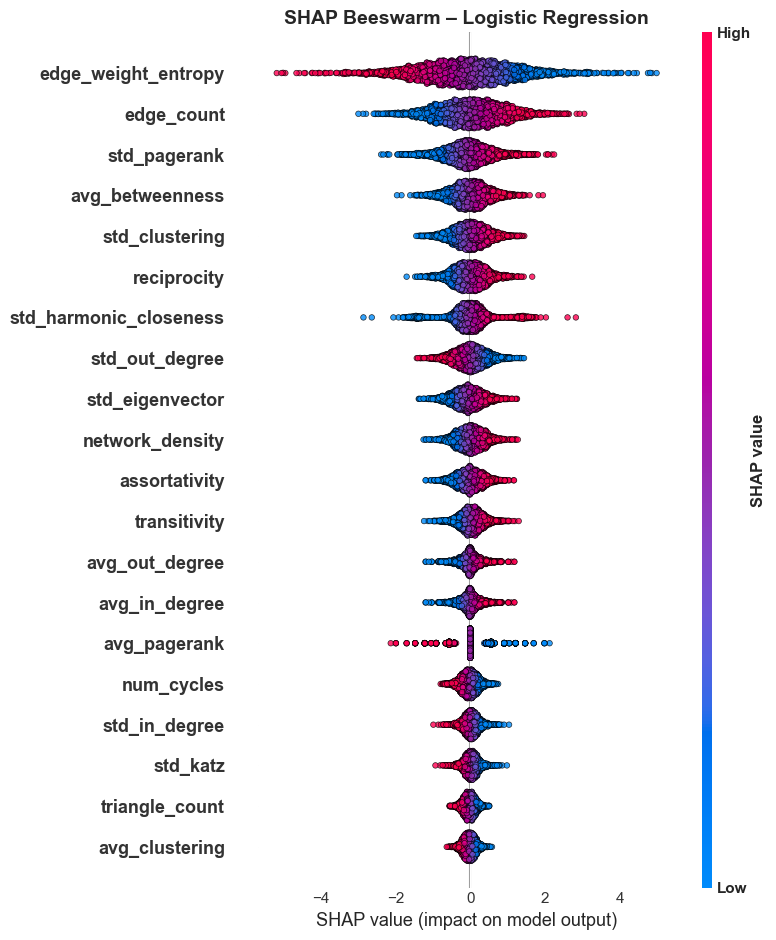

In [19]:
plt.figure(figsize=(12, 8))
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

shap.summary_plot(
    shap_values,
    X_train_scaled,
    feature_names=feature_columns,
    plot_type="dot",
    max_display=20,
    show=False,
    alpha=0.8
)

ax = plt.gca()

y_tick_labels = ax.get_yticklabels()
for label in y_tick_labels:
    label.set_fontweight('bold')
ax.set_yticklabels(y_tick_labels)

for collection in ax.collections:
    if hasattr(collection, 'set_edgecolor'):
        collection.set_edgecolor('black')
        collection.set_linewidth(0.5)

for cbar in plt.gcf().axes:
    if cbar != ax:
        cbar.set_ylabel('SHAP value', fontweight='bold')
        for label in cbar.get_yticklabels():
            label.set_fontweight('bold')
        break

plt.title("SHAP Beeswarm – Logistic Regression", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

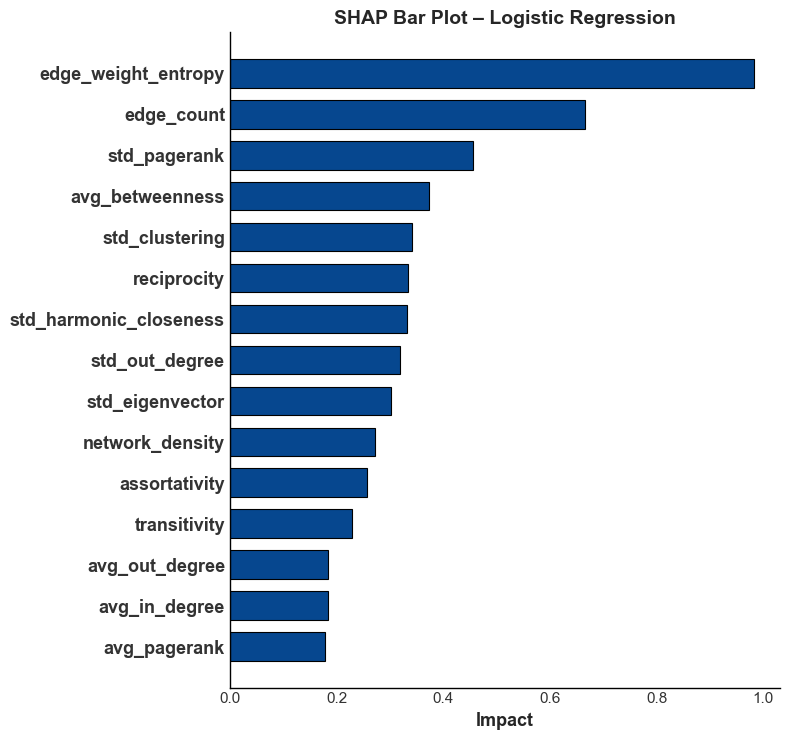

In [20]:
plt.figure(figsize=(10, 6))

shap.summary_plot(
    shap_values,
    X_train_scaled,
    feature_names=feature_columns,
    plot_type="bar",
    max_display=15,
    show=False,
    color='#06478f'  
)

ax = plt.gca()

for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(0.8)

for line in ax.lines:
    line.remove()  

ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)

y_tick_labels = ax.get_yticklabels()
for label in y_tick_labels:
    label.set_fontweight('bold')
ax.set_yticklabels(y_tick_labels)

ax.set_xlabel("Impact", fontweight='bold')

plt.title("SHAP Bar Plot – Logistic Regression", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
print("\n=== DETAILED ANALYSIS OF SHAP VALUES (ORDERED BY IMPORTANCE) ===\n")

feature_importance = []
for i, feature in enumerate(feature_columns):
    mean_abs_shap = np.abs(shap_values[:, i]).mean()
    feature_importance.append((feature, i, mean_abs_shap))

feature_importance.sort(key=lambda x: x[2], reverse=True)

feature_importance_data = []

for feature_name, feature_idx, importance in feature_importance[:20]:
    shap_feature = shap_values[:, feature_idx]
    feature_values = X_train_scaled[:, feature_idx]
    correlation = np.corrcoef(feature_values, shap_feature)[0, 1]
    positive_shap = shap_feature[shap_feature > 0]
    negative_shap = shap_feature[shap_feature < 0]
    feature_when_positive = feature_values[shap_feature > 0]
    feature_when_negative = feature_values[shap_feature < 0]

    stats = {
        'feature': feature_name,
        'feature_idx': feature_idx,
        'importance': importance,
        'shap_min': shap_feature.min(),
        'shap_max': shap_feature.max(),
        'shap_mean': shap_feature.mean(),
        'shap_std': shap_feature.std(),
        'correlation': correlation,
        'percent_positive': (len(positive_shap) / len(shap_feature)) * 100,
        'percent_negative': (len(negative_shap) / len(shap_feature)) * 100,
        'avg_feature_when_positive': feature_when_positive.mean() if len(feature_when_positive) > 0 else 0,
        'avg_feature_when_negative': feature_when_negative.mean() if len(feature_when_negative) > 0 else 0,
    }

    feature_importance_data.append(stats)

for i, stats in enumerate(feature_importance_data[:8]):
    print(f"### {i+1}. {stats['feature']} (Importância: {stats['importance']:.3f})")
    print(f"   - SHAP range: [{stats['shap_min']:.3f}, {stats['shap_max']:.3f}]")
    print(f"   - Mean SHAP: {stats['shap_mean']:.3f} (±{stats['shap_std']:.3f})")
    print(f"   - Correlation (feature vs SHAP): {stats['correlation']:.3f}")

    if stats['correlation'] > 0.1:
        print("   - Interpretation: High feature values → POSITIVE impact on prediction")
        print("   - Low feature values → NEGATIVE impact on prediction")
    elif stats['correlation'] < -0.1:
        print("   - Interpretation: High feature values → NEGATIVE impact on prediction")
        print("   - Low feature values → POSITIVE impact on prediction")
    else:
        print("   - Interpretation: NON-LINEAR or complex relationship")
        print(f"   - Average feature value when SHAP>0: {stats['avg_feature_when_positive']:.3f}")
        print(f"   - Average feature value when SHAP<0: {stats['avg_feature_when_negative']:.3f}")

    print(f"   - {stats['percent_positive']:.1f}% of cases have positive SHAP")
    print(f"   - {stats['percent_negative']:.1f}% of cases have negative SHAP")
    print()

print("\n=== ANALYSIS OF NON-LINEAR PATTERNS ===\n")

for stats in feature_importance_data[:8]:
    feature_name = stats['feature']
    feature_idx = stats['feature_idx']
    
    shap_feature = shap_values[:, feature_idx]
    feature_values = X_train_scaled[:, feature_idx]
    
    q1, q2, q3 = np.percentile(feature_values, [25, 50, 75])
    shap_q1 = shap_feature[feature_values <= q1].mean()
    shap_q2 = shap_feature[(feature_values > q1) & (feature_values <= q2)].mean()
    shap_q3 = shap_feature[(feature_values > q2) & (feature_values <= q3)].mean()
    shap_q4 = shap_feature[feature_values > q3].mean()

    print(f"{feature_name}:")
    print(f"   Q1 (low values): mean SHAP = {shap_q1:.3f}")
    print(f"   Q2: mean SHAP = {shap_q2:.3f}")
    print(f"   Q3: mean SHAP = {shap_q3:.3f}")
    print(f"   Q4 (high values): mean SHAP = {shap_q4:.3f}")

    if shap_q1 < 0 and shap_q4 > 0:
        print("   → Pattern: Monotonically increasing (the higher the metric, the better)")
    elif shap_q1 > 0 and shap_q4 < 0:
        print("   → Pattern: Monotonically decreasing (the lower the metric, the better)")
    elif (shap_q2 > shap_q1 and shap_q2 > shap_q4) or (shap_q3 > shap_q1 and shap_q3 > shap_q4):
        print("   → Pattern: Intermediate values are favored")
    elif (shap_q1 > shap_q2 and shap_q4 > shap_q3):
        print("   → Pattern: Extreme values are favored")
    else:
        print("   → Pattern: Complex/non-linear")

    print()


=== ANÁLISE DETALHADA DOS VALORES SHAP (ORDENADO POR IMPORTÂNCIA) ===

### 1. edge_weight_entropy (Importância: 0.982)
   - SHAP range: [-5.173, 4.985]
   - Mean SHAP: -0.094 (±1.256)
   - Correlation (feature vs SHAP): -1.000
   - Interpretation: High feature values → NEGATIVE impact on prediction
   - Low feature values → POSITIVE impact on prediction
   - 47.0% of cases have positive SHAP
   - 53.0% of cases have negative SHAP

### 2. edge_count (Importância: 0.666)
   - SHAP range: [-2.989, 3.051]
   - Mean SHAP: 0.031 (±0.837)
   - Correlation (feature vs SHAP): 1.000
   - Interpretation: High feature values → POSITIVE impact on prediction
   - Low feature values → NEGATIVE impact on prediction
   - 51.0% of cases have positive SHAP
   - 49.0% of cases have negative SHAP

### 3. std_pagerank (Importância: 0.456)
   - SHAP range: [-2.381, 2.245]
   - Mean SHAP: -0.068 (±0.589)
   - Correlation (feature vs SHAP): 1.000
   - Interpretation: High feature values → POSITIVE impact on p


=== SHAP vs FEATURE SCATTER PLOTS ===


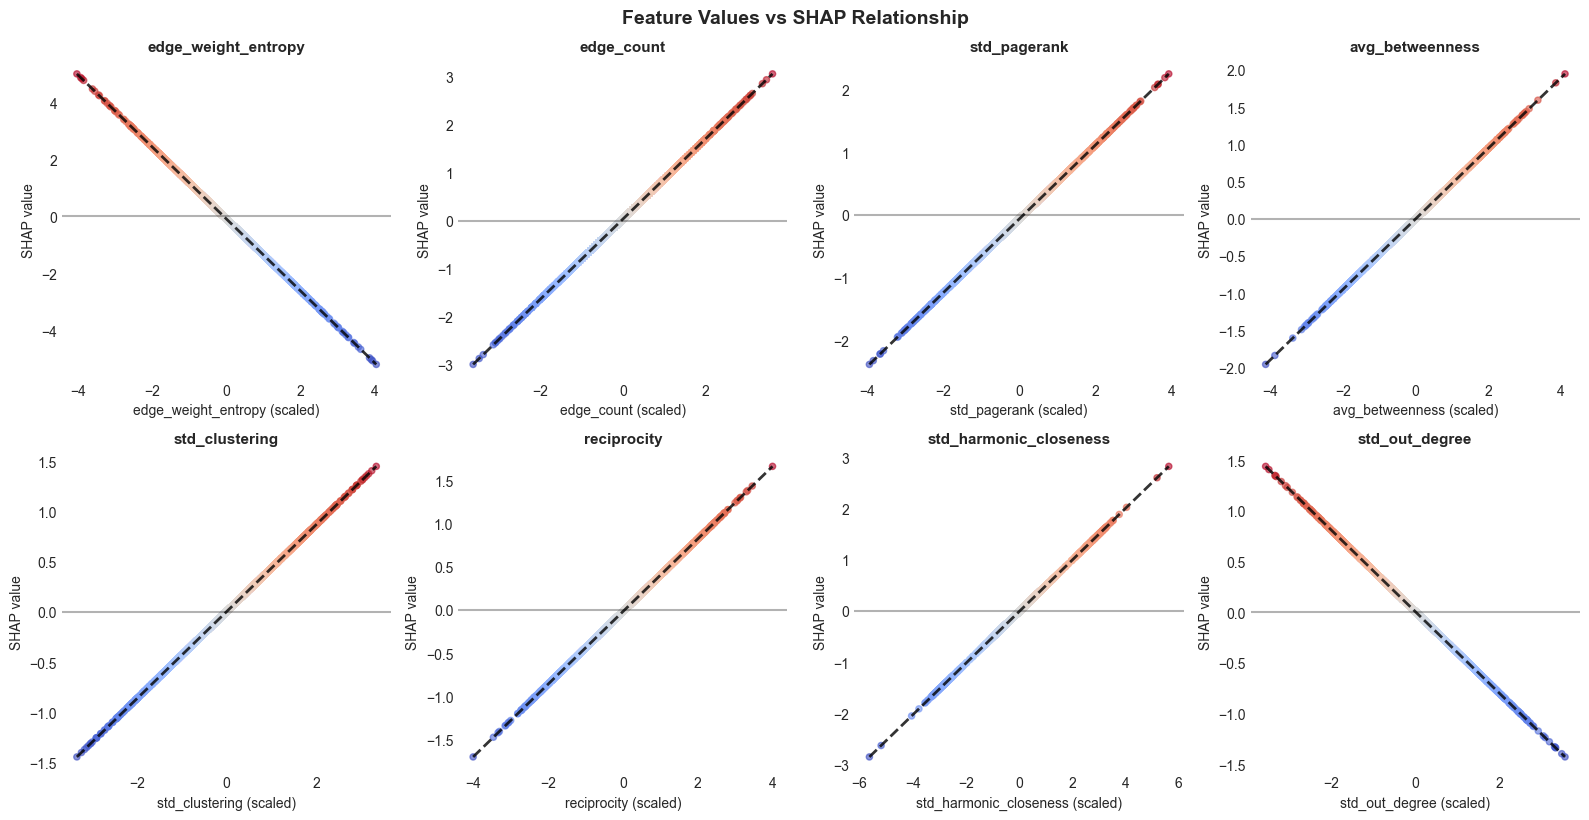

In [28]:
print("\n=== SHAP vs FEATURE SCATTER PLOTS ===")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, stats in enumerate(feature_importance_data[:8]):
    ax = axes[i]
    feature_name = stats['feature']
    feature_idx = stats['feature_idx']
    
    scatter = ax.scatter(
        X_train_scaled[:, feature_idx],
        shap_values[:, feature_idx],
        c=shap_values[:, feature_idx],
        cmap='coolwarm',
        alpha=0.6,
        s=20
    )
    
    z = np.polyfit(X_train_scaled[:, feature_idx], shap_values[:, feature_idx], 1)
    p = np.poly1d(z)
    x_line = np.linspace(
        X_train_scaled[:, feature_idx].min(),
        X_train_scaled[:, feature_idx].max(),
        100
    )
    ax.plot(x_line, p(x_line), "k--", alpha=0.8, linewidth=2)
    
    ax.set_xlabel(f'{feature_name} (scaled)', fontsize=10)
    ax.set_ylabel('SHAP value', fontsize=10)
    ax.set_title(f'{feature_name}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.suptitle('Feature Values vs SHAP Relationship', fontsize=14, fontweight='bold', y=1.02)
plt.show()